## LSTM


In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import and show dataset
data = pd.read_csv("TUNINDEX_1.csv")
print("Shape of Data: ", data.shape)
data.head()

Shape of Data:  (1033, 13)


,Date,High,Close,Low,Open,Ind_Name,std_close,ROI,7_Days_Average_ROI,ROI_Monthly_Avg,Kurtosis,Skewness,yearly_std
0,2020-01-02,7097.940,7042.642,7036.285,7095.456,TUNINDEX,758.379164,-0.744336,-0.444975,-0.065224,1.376302,-1.873376,247.720706
1,2020-01-03,7030.798,6994.840,6975.302,7035.436,TUNINDEX,758.379164,-0.577022,-0.444975,-0.065224,1.376302,-1.873376,247.720706
2,2020-01-06,7031.427,6967.192,6946.489,6991.819,TUNINDEX,758.379164,-0.352226,-0.444975,-0.065224,1.376302,-1.873376,247.720706
3,2020-01-07,6976.397,6921.921,6906.640,6965.572,TUNINDEX,758.379164,-0.626668,-0.444975,-0.065224,1.376302,-1.873376,247.720706
4,2020-01-08,6927.413,6892.276,6868.117,6926.235,TUNINDEX,758.379164,-0.490295,-0.444975,-0.065224,1.376302,-1.873376,247.720706


In [ ]:
data.describe()

,High,Close,Low,Open,std_close,ROI,7_Days_Average_ROI,ROI_Monthly_Avg,Kurtosis,Skewness,yearly_std
count,1033.000000,1033.000000,1033.000000,1033.000000,1.033000e+03,1033.000000,1033.000000,1033.000000,1033.000000,1033.000000,1033.000000
mean,7525.544652,7504.137266,7476.347848,7505.690026,7.583792e+02,-0.024375,-0.024375,-0.024375,0.526010,-0.303047,306.138119
std,756.158006,758.379164,757.454017,755.266699,1.137419e-13,0.430950,0.223887,0.065404,0.481565,0.896960,89.473567
min,6158.584000,6119.135000,6001.981000,6031.734000,7.583792e+02,-4.024885,-1.351345,-0.143855,0.140139,-1.873376,77.922363
25%,6916.980000,6894.639000,6868.117000,6898.964000,7.583792e+02,-0.221304,-0.109216,-0.065224,0.223210,-0.544470,240.291268
50%,7296.658000,7280.226000,7255.941000,7279.550000,7.583792e+02,-0.000852,-0.002524,-0.054263,0.271862,0.173647,247.720706
75%,8177.601000,8161.783000,8123.359000,8161.167000,7.583792e+02,0.203991,0.110140,0.010041,0.281762,0.217881,312.298313
max,9064.289000,9048.479000,9027.707000,9048.656000,7.583792e+02,2.102066,0.442707,0.104458,1.376302,0.283938,444.464923


In [ ]:
# Drop the row with NaN
data=data.dropna(how='any',axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1033 entries, 0 to 1032
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                1033 non-null   object 
 1   High                1033 non-null   float64
 2   Close               1033 non-null   float64
 3   Low                 1033 non-null   float64
 4   Open                1033 non-null   float64
 5   Ind_Name            1033 non-null   object 
 6   std_close           1033 non-null   float64
 7   ROI                 1033 non-null   float64
 8   7_Days_Average_ROI  1033 non-null   float64
 9   ROI_Monthly_Avg     1033 non-null   float64
 10  Kurtosis            1033 non-null   float64
 11  Skewness            1033 non-null   float64
 12  yearly_std          1033 non-null   float64
dtypes: float64(11), object(2)
memory usage: 105.0+ KB


In [ ]:
# Assuming 'Close' is the column you want to select
close_prices = data['Close']

# Convert the 'Close' prices to a numpy array
close_prices_array = close_prices.values

print(close_prices_array[:5])


[7042.642 6994.84  6967.192 6921.921 6892.276]


In [ ]:
# Assuming close_prices_array is the 1D array of 'Close' prices
close_prices_array = np.array(close_prices)

# Reshape the array to 2D
close_prices_array = close_prices_array.reshape(-1, 1)

# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(close_prices_array)

print(df_scaled[:5])

[[0.31526069]
 [0.29894236]
 [0.28950407]
 [0.27404975]
 [0.26392974]]


In [ ]:
# Split data into predictors and outcomes
# predict the number of passengers using by the past 6 months' number of passengers
X=[]
y=[]
sequence=6
for i in range(len(df_scaled) - sequence):
    X.append(df_scaled[i:(i + sequence),0]) # appends a slice of the df_scaled array to the X list. The slice starts at index i and ends at index i + sequence - 1.
                                            #The ,0 at the end specifies that only the values in the first column of the slice should be included.
    y.append(df_scaled[i + sequence,0])
X,y=np.array(X),np.array(y)

In [ ]:
print("Predictors")
print(X[:5]) #print the elements from index 0 to index 4
print("Outcomes")
print(y[:5])

Predictors
[[0.31526069 0.29894236 0.28950407 0.27404975 0.26392974 0.2613056 ]
 [0.29894236 0.28950407 0.27404975 0.26392974 0.2613056  0.25551181]
 [0.28950407 0.27404975 0.26392974 0.2613056  0.25551181 0.26002033]
 [0.27404975 0.26392974 0.2613056  0.25551181 0.26002033 0.26812112]
 [0.26392974 0.2613056  0.25551181 0.26002033 0.26812112 0.27374388]]
Outcomes
[0.25551181 0.26002033 0.26812112 0.27374388 0.26738922]


In [ ]:
# Reshape the predictor
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
# reshape the X array to a 3D tensor with a shape of (samples, timesteps, features)
X.shape
# By reshaping the X array in this way, we can prepare the data to be used in a recurrent neural network (RNN)
#model. The samples dimension represents the number of data points, the timesteps dimension represents
#the number of time steps in each sequence, and the features dimension represents the number of features in the data.
#This is a standard format for RNN inputs, which can be used to train models that can analyze sequential data.

(1027, 6, 1)

In [ ]:
# Split data into training and test sets

# Set the size of training and test data
# Use 75% of the data for training
train_size = math.ceil(len(X) * 0.75) # returns the smallest integer greater than or equal to x
test_size = len(X - train_size)

# Split X and y into training and test sets
X_train = X[:train_size, :]
y_train = y[:train_size]

X_test = X[train_size:len(X),:] # This is a slice of the original X array that includes all rows starting from index train_size
                                #and going up to the last row of X. The , and : are used to include all columns of the array.
y_test = y[train_size:len(y)]

In [ ]:
# Show the size of training and test sets
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

X_train:  (771, 6, 1)
y_train:  (771,)
X_test :  (256, 6, 1)
y_test :  (256,)


## LSTM layer:
number_of_trainable_parameters = num_params = units(units + input_dim + 1)

*input dimension for the first layer=1 because the input data X_train is a univariate time series, meaning that it only has one feature or variable being observed over time


In [ ]:
# LSTM model
lstm=Sequential()
lstm.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm.add(LSTM(units=32, return_sequences=True))
lstm.add(LSTM(units=32, return_sequences=True))
lstm.add(LSTM(units=32))
lstm.add(Dense(units=1))
lstm.compile(optimizer='adam', loss='mean_squared_error')
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 32)             4352      
                                                                 
 lstm_1 (LSTM)               (None, 6, 32)             8320      
                                                                 
 lstm_2 (LSTM)               (None, 6, 32)             8320      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## LSTM layer:



ps: n for the first layer is 1 (1 sequence)

## dense layer:

number_of_trainable_parameters = (input_size x output_size) + output_size


In [ ]:
# Set Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=40)

In [ ]:
# Fit LSTM model
lstm_history = lstm.fit(X_train, y_train, batch_size=16, epochs=1000,
                        validation_split=0.2, callbacks=[early_stop], verbose=0)

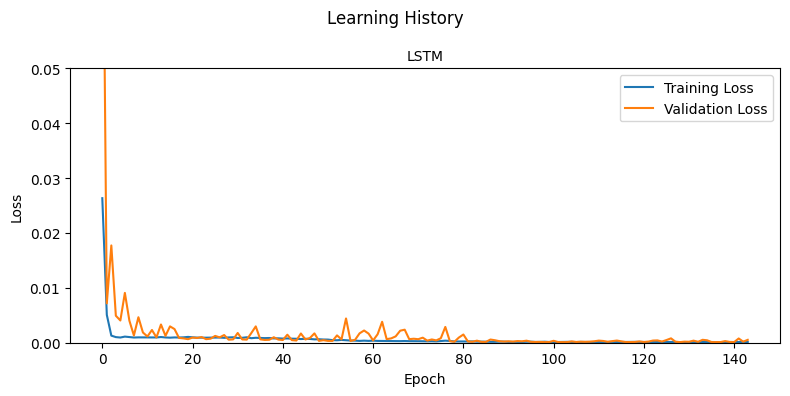

In [ ]:
import matplotlib.pyplot as plt

# Set subplot titles
titles = ['LSTM']

# Create a list of training histories (assuming lstm_history contains LSTM training history)
models = [lstm_history]

# Set the plot area
fig, ax = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)

# Plot learning history
plt.suptitle('Learning History')
for i in range(len(models)):
    plt.plot(models[i].history['loss'], label='Training Loss')
    plt.plot(models[i].history['val_loss'], label='Validation Loss')
    plt.title(titles[i], fontsize=10)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.ylim([0, 0.05])

plt.show()


In [ ]:
# Make predictions and reverse the predicted value to real number



# Predict by LSTM model
lstm_y_pred=lstm.predict(X_test)
lstm_y_pred=scaler.inverse_transform(lstm_y_pred)



# Reverse test data to real number
y_test=y_test.reshape(y_test.shape[0],1)
y_test=scaler.inverse_transform(y_test)

8/8 [==============================] - 2s 6ms/step


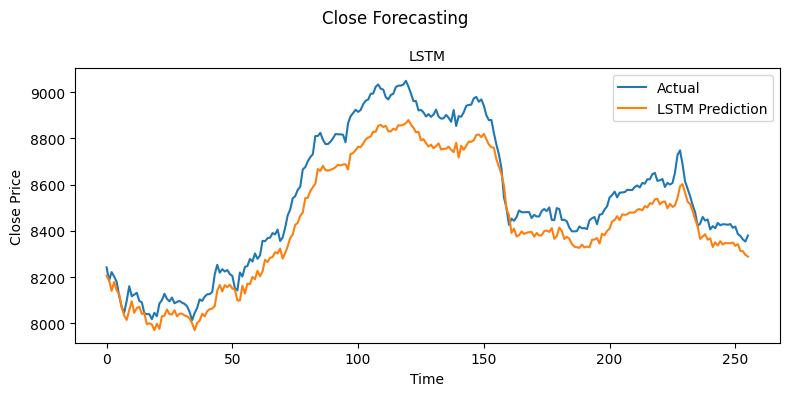

In [ ]:
import matplotlib.pyplot as plt

# Set subplot titles
titles = ['LSTM']

# Create a list of prediction models (assuming lstm_y_pred contains LSTM predictions)
models = [lstm_y_pred]

# Set the plot area
fig, ax = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)

# Set the title
plt.suptitle('Close Forecasting')

# Create and show subplots
for i in range(len(models)):
    plt.plot(y_test, label='Actual')
    plt.plot(models[i], label='LSTM Prediction')
    plt.title(titles[i], fontsize=10)
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Close Price')

plt.show()


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error


r2 = r2_score(y_test, lstm_y_pred)
print("R^2 Score:", r2)
print(f'mean_squared_error = {mean_squared_error(y_test, lstm_y_pred)}')
rmse = math.sqrt(mean_squared_error(y_test, lstm_y_pred))
print("The root mean squared error is {}.".format(rmse))



R^2 Score: nan


TypeError: unsupported operand type(s) for -: 'ellipsis' and 'ellipsis'

In [ ]:
def mean_absolute_percentage_error(y_test, lstm_y_pred):
    y_test, lstm_y_pred = np.array(y_test), np.array(lstm_y_pred)
    return np.mean(np.abs((y_test - lstm_y_pred) / y_test)) * 100

In [ ]:
mape = mean_absolute_percentage_error(y_test, lstm_y_pred)
print("Mean Absolute Percentage Error:", mape)

Mean Absolute Percentage Error: 3.8020194418404247


In [ ]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae = mean_absolute_error(y_test, lstm_y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

TypeError: unsupported operand type(s) for -: 'ellipsis' and 'ellipsis'

## XGBOOST

Here I split stock data frame into three subsets: training ( 70%
 ), validation ( 15%
 ) and test ( 15%
 ) sets. I calculated split indices and create three separate frames (train_df, valid_df, test_df). All three frames have been ploted in the chart below.

In [ ]:
import plotly.graph_objects as go

test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(data.shape[0] * (1-test_size))
valid_split_idx = int(data.shape[0] * (1-(valid_size+test_size)))

train_df  = data.loc[:valid_split_idx].copy()
valid_df  = data.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = data.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

In [ ]:
drop_cols = ['Date',  'Open', 'Low', 'High', 'Ind_Name']

train_df = train_df.drop(columns=drop_cols)
valid_df = valid_df.drop(columns=drop_cols)
test_df = test_df.drop(columns=drop_cols)


In [ ]:
y_train = train_df['Close'].copy()
X_train = train_df.drop(columns=['Close'])

y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(columns=['Close'])

y_test = test_df['Close'].copy()
X_test = test_df.drop(columns=['Close'])

X_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 724 entries, 0 to 723
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   std_close           724 non-null    float64
 1   ROI                 724 non-null    float64
 2   7_Days_Average_ROI  724 non-null    float64
 3   ROI_Monthly_Avg     724 non-null    float64
 4   Kurtosis            724 non-null    float64
 5   Skewness            724 non-null    float64
 6   yearly_std          724 non-null    float64
dtypes: float64(7)
memory usage: 39.7 KB


In [ ]:
from xgboost import XGBRegressor


# 3. Model training
model = XGBRegressor()
model.fit(X_train, y_train)

# 4. Model evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 2323609.9379561897


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
import time



parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')




Best params: {'gamma': 0.001, 'learning_rate': 0.005, 'max_depth': 15, 'n_estimators': 300, 'random_state': 42}
Best validation score = -5.426355705603216


In [ ]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: user 1.39 s, sys: 18.9 ms, total: 1.4 s
Wall time: 719 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.001, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

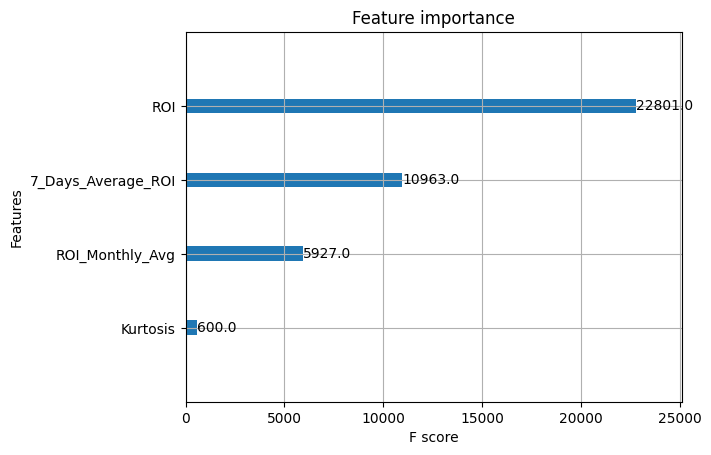

In [ ]:
plot_importance(model);

In [ ]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [8946.812 8962.321 8967.419 8992.281 8993.469]
y_pred = [7190.553  7251.1904 7251.1904 7230.032  7230.032 ]


In [ ]:
from sklearn.metrics import mean_squared_error
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 2302395.0817988217


In [ ]:
from plotly.subplots import make_subplots

predicted_prices = data.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=data.Date, y=data.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

# SARIMAX

In [ ]:
import plotly.graph_objects as go

test_size  = 0.2


test_split_idx  = int(data.shape[0] * (1-test_size))


train_sarimax  = data.loc[:test_split_idx].copy()

test_sarimax   = data.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_sarimax.Date, y=train_sarimax.Close, name='Training'))
fig.add_trace(go.Scatter(x=test_sarimax.Date,  y=test_sarimax.Close,  name='Test'))
fig.show()

In [ ]:
print(len(train_sarimax))

827


In [ ]:
train_sarimax = train_sarimax['Close']
test_sarimax = test_sarimax['Close']


In [ ]:
pip install pmdarima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.7 MB/s eta 0:00:00


In [ ]:
from pmdarima.arima import auto_arima
arima_m = auto_arima(data['Close'],trace=True ,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9965.144, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10066.051, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9960.328, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9974.527, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10065.774, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9961.546, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9961.604, Time=0.45 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9963.388, Time=1.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=9959.205, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=9960.371, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=9960.427, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=9973.672, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=9962.221, Time=0.31 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.999 seconds


In [ ]:
# forcibly disable system warnings
import warnings
warnings.simplefilter(action = 'ignore', category = Warning)

# let's train the model with the appropriate parameters, SARIMAX(0, 1, 0)x(0, 1, 0, 12)
# importing the model class
from statsmodels.tsa.statespace.sarimax import SARIMAX

# let's create an object of this model
model = SARIMAX(train_sarimax,
                order = (1, 1, 0),
                seasonal_order = (1, 1, 0, 12),
                enforce_stationarity = False,
                enforce_invertibility = False)

# apply the method fit
result_sarimax = model.fit(maxiter = 500, method = 'nm')

Optimization terminated successfully.
         Current function value: 4.882488
         Iterations: 63
         Function evaluations: 116


In [ ]:
# the test forecast period will start from the end of the training period
start = len(train_sarimax)

# and it will end at the end of the test
end = len(train_sarimax) + len(test_sarimax) - 1

# apply the method predict
predictions = result_sarimax.predict(start, end)
predictions

827     8206.760702
828     8200.864135
829     8208.076595
830     8209.937755
831     8210.904973
           ...     
1028    9306.094873
1029    9317.589174
1030    9317.891692
1031    9311.454336
1032    9313.479119
Name: predicted_mean, Length: 206, dtype: float64

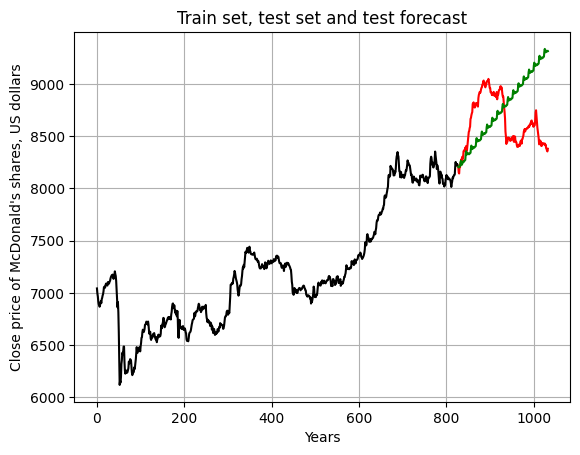

In [ ]:
# we will output three curves (training, test set and test forecast)
plt.plot(train_sarimax, color = "black")
plt.plot(test_sarimax, color = "red")
plt.plot(predictions, color = "green")

# title and axis captions
plt.title("Train set, test set and test forecast")
plt.ylabel("Close price of McDonald's shares, US dollars")
plt.xlabel('Years')

# add a grid
plt.grid()

plt.show()

In [ ]:
# importing a metric
from sklearn.metrics import mean_squared_error

# calculate MSE
print('MSE = ', mean_squared_error(test_sarimax, predictions))

# and RMSE
print('RMSE = ', np.sqrt(mean_squared_error(test_sarimax, predictions)))

r2 = r2_score(test_sarimax, predictions)
print("R^2 Score:", r2)

MSE =  214411.5194064416
RMSE =  463.04591500891314
R^2 Score: -2.8861001810535662


In [ ]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae = mean_absolute_error(test_sarimax, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 405.98014971362204


In [ ]:
mape = mean_absolute_percentage_error(test_sarimax, predictions)
print("Mean Absolute Percentage Error:", mape)

Mean Absolute Percentage Error: 4.714092521168165
